In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Dataset

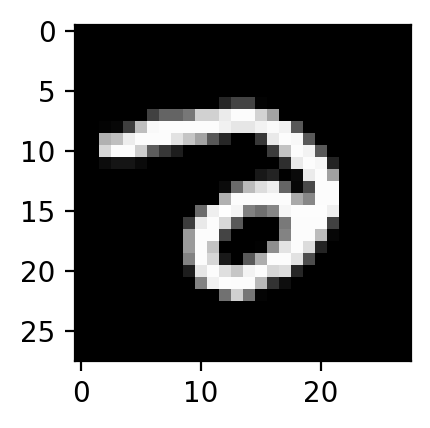

x_shape: torch.Size([128, 1, 28, 28])
min: 0.0 max: 1.0
mean: 0.13336342573165894, var: 0.09620027244091034


In [3]:
data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
    transform=torchvision.transforms.ToTensor(),
    download=True),
    batch_size=128,
    shuffle=True)

x, y = next(iter(data))     # Shape: (batch_size, 1, 28, 28)
x_sample = torch.permute(x[0], (2, 1, 0))

ax = plt.subplot(211)
ax.imshow(x_sample, cmap="gray")
plt.show()

print(f"x_shape: {x.shape}")
print(f"min: {torch.min(x_sample)} max: {torch.max(x_sample)}")
print(f"mean: {torch.mean(x)}, var: {torch.var(x)}")

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.decoder_ff = nn.Sequential(
            # nn.Linear(latent_dim, 256),
            # nn.Mish(),
            # nn.Linear(256, 512),
            # nn.Mish(),
            nn.Linear(latent_dim, 512),
            nn.Mish(),
            nn.Linear(512, 28*28), # 28 * 28 = 784
            nn.Sigmoid(),
        )

    def forward(self, x):
        decoder_out = self.decoder_ff(x)
        return decoder_out.view((-1, 1, 28, 28))


class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.encoder_ff = nn.Sequential(
            nn.Linear(28*28, 512),
            # nn.Mish(),
            # nn.Linear(512, 256),
            nn.Mish(),
        )
        self.mean_linear = nn.Linear(512, latent_dim)
        self.logstd_linear = nn.Linear(512, latent_dim)

        self.kl = 0
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.encoder_ff(x)
        mu = self.mean_linear(x)
        sigma = torch.exp(self.logstd_linear(x))
        
        # Reparamitization step
        # Extract the device from the input for reparam step
        z = mu + sigma * torch.randn(mu.shape).to(x.device) 

        # KL calculation - (EQN 17.24)
        # Is this the same? Seems a little different
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return z
    
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


# -- Testing params
latent_dim = 5
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -- Testing enoder/decoder module

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)

x_sample = torch.randn((batch_size, 1, 28, 28)).to(device)
encoder_out = encoder(x_sample.flatten(start_dim=1))


print(f"x_sample: {x_sample.shape}")

# -- Testing variational autencoder module
latent_dim = 5
vae = VAE(latent_dim=latent_dim).to(device)

x_sample = torch.randn((batch_size, 1, 28, 28)).to(device)
xhat = vae(x_sample)

print(f"xhat: {xhat.shape}")
print(f"vae encoder kl: {vae.encoder.kl}")

x_sample: torch.Size([32, 1, 28, 28])
xhat: torch.Size([32, 1, 28, 28])
vae encoder kl: 100.84596252441406


In [5]:
# -- Training setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_EPOCHS = 20
LATENT_DIM = 2

epoch_losses = []

# -- Training
vae = VAE(latent_dim=LATENT_DIM).to(device)

# TODO: Try scaling mnist data as well

opt = torch.optim.Adam(vae.parameters())
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    for x, y in data:
        x = x.to(device) # GPU
        opt.zero_grad()

        # Prediction 
        x_hat = vae(x)
        
        # Loss + backprop
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl
        loss.backward()

        epoch_loss += loss

        # Optimizer step
        opt.step()

    print(f"epoch {epoch}, epoch loss: {epoch_loss}")
    epoch_losses.append(epoch_loss.item())

epoch 0, epoch loss: 2957272.5
epoch 1, epoch loss: 2673772.0
epoch 2, epoch loss: 2631089.0
epoch 3, epoch loss: 2594795.0
epoch 4, epoch loss: 2565390.75
epoch 5, epoch loss: 2543421.0
epoch 6, epoch loss: 2527588.5
epoch 7, epoch loss: 2511505.25
epoch 8, epoch loss: 2499342.5
epoch 9, epoch loss: 2489224.25
epoch 10, epoch loss: 2478390.0
epoch 11, epoch loss: 2468920.25
epoch 12, epoch loss: 2461100.25
epoch 13, epoch loss: 2453320.0
epoch 14, epoch loss: 2445928.0
epoch 15, epoch loss: 2439921.25
epoch 16, epoch loss: 2434653.25
epoch 17, epoch loss: 2427427.0
epoch 18, epoch loss: 2423793.5
epoch 19, epoch loss: 2418434.25


Text(0.5, 1.0, 'Epoch Loss')

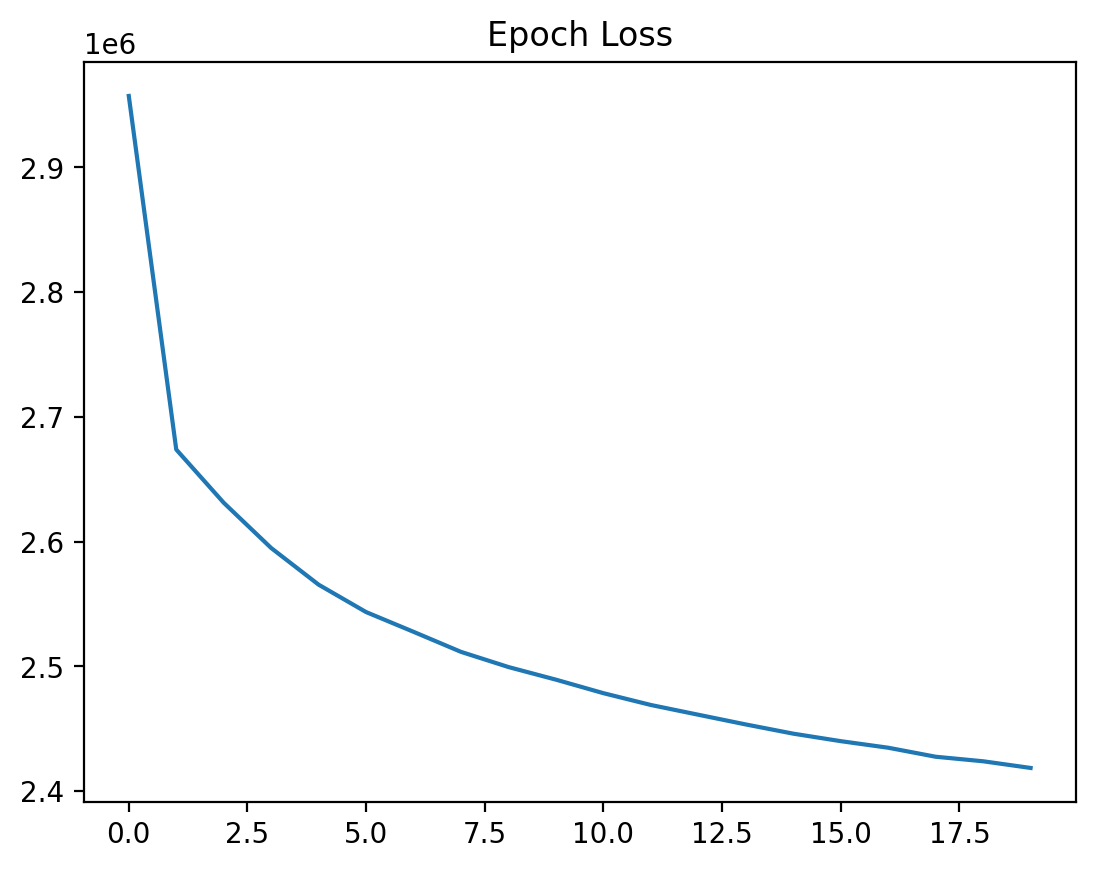

In [6]:
plt.plot(np.arange(0, NUM_EPOCHS, 1), epoch_losses)
plt.title("Epoch Loss")

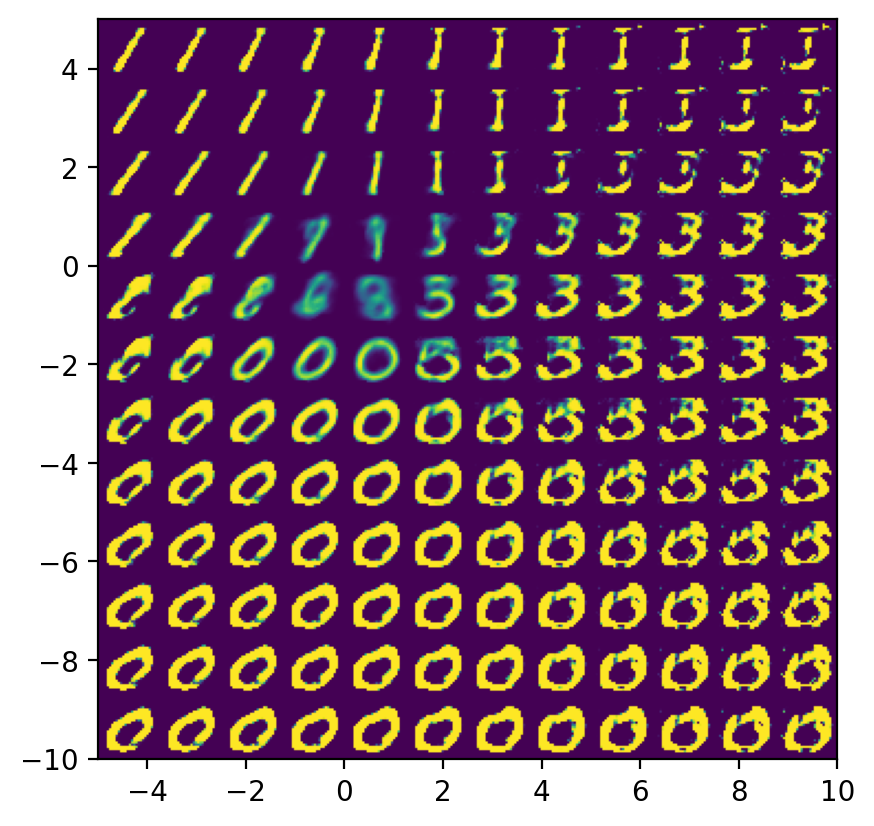

In [7]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))

    # Iterate through latent space and generate output
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

plot_reconstructed(vae)

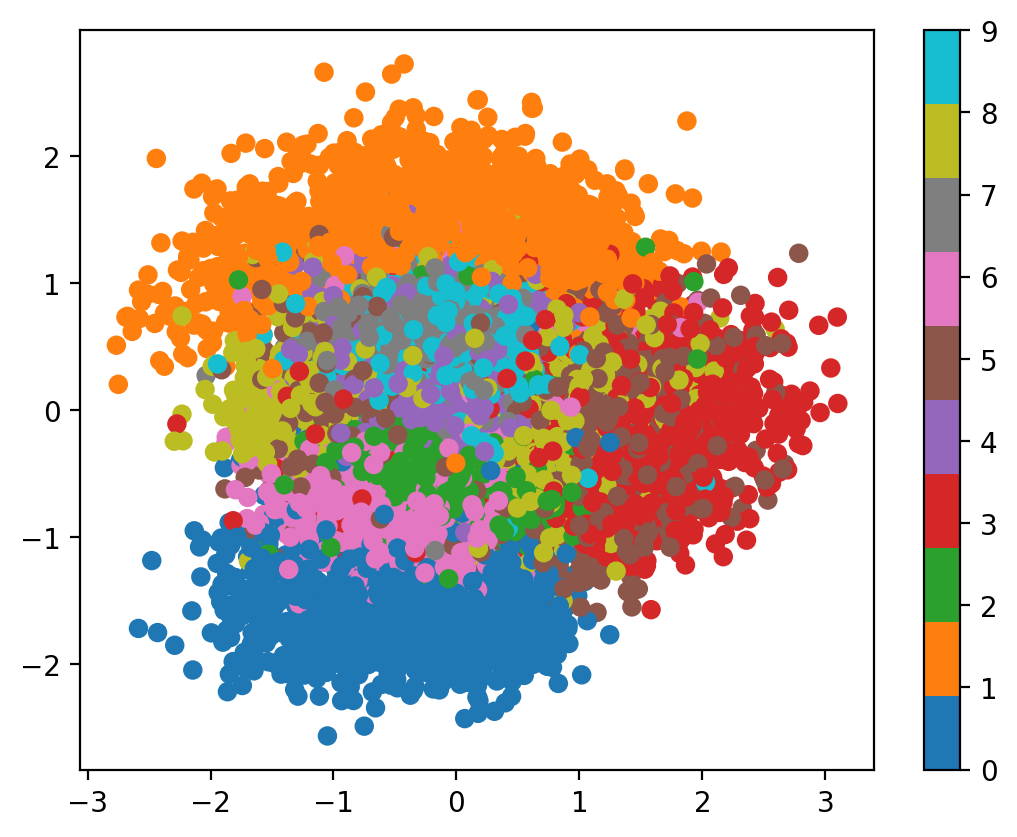

: 

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

plot_latent(vae, data)
